# 🧠 Frozen vs Full Fine-tuning Analysis

## 📚 Import Necessary Libraries

In [15]:
import os
import yaml
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [16]:
# Configuration
BASE_DIR = 'runs/train'
print(f"Analyzing: {BASE_DIR}\n")

Analyzing: runs/train



## 🤖 YOLO11n Parameters

### 📋 Layer-by-Layer Breakdown

Here's the model architecture from YOLO11 output:

| Layer | Module | Params | Frozen? |
|-------|--------|--------|---------|
| 0 | Conv [3,16,3,2] | 464 | ✅ |
| 1 | Conv [16,32,3,2] | 4,672 | ✅ |
| 2 | C3k2 [32,64,1,False,0.25] | 6,640 | ✅ |
| 3 | Conv [64,64,3,2] | 36,992 | ✅ |
| 4 | C3k2 [64,128,1,False,0.25] | 26,080 | ✅ |
| 5 | Conv [128,128,3,2] | 147,712 | ✅ |
| 6 | C3k2 [128,128,1,True] | 87,040 | ✅ |
| 7 | Conv [128,256,3,2] | 295,424 | ✅ |
| 8 | C3k2 [256,256,1,True] | 346,112 | ✅ |
| 9 | SPPF [256,256,5] | 164,608 | ✅ |
| 10 | C2PSA [256,256,1] | 249,728 | ❌ |
| 11-15 | Upsample/Concat blocks | 0 | ❌ |
| 16 | C3k2 [256,64,1,False] | 32,096 | ❌ |
| 17 | Conv [64,64,3,2] | 36,992 | ❌ |
| 18-21 | Concat blocks | 0 | ❌ |
| 19 | C3k2 [192,128,1,False] | 86,720 | ❌ |
| 20 | Conv [128,128,3,2] | 147,712 | ❌ |
| 22 | C3k2 [384,256,1,True] | 378,880 | ❌ |
| 23 | Detect [80,[64,128,256]] | 464,912 | ❌ |

In [ ]:
# YOLO11n Parameters
def compute_trainable_params_factual(freeze_layers):
    """Compute trainable parameters based on EXACT YOLO11n layer counts."""
    total_params = 2_624_080
    
    frozen_layer_params = {
        0: 464,     
        1: 4_672,  
        2: 6_640,   
        3: 36_992,   
        4: 26_080,  
        5: 147_712, 
        6: 87_040,  
        7: 295_424, 
        8: 346_112, 
        9: 164_608 
    }
    
    if freeze_layers == 0:
        return total_params, 100.0
    elif freeze_layers == 10:
        frozen_params = sum(frozen_layer_params.values())
        trainable_params = total_params - frozen_params
        trainable_pct = (trainable_params / total_params) * 100
        return trainable_params, trainable_pct
    else:
        raise ValueError(f"No factual data for freeze_layers={freeze_layers}. Only 0 and 10 are supported.")

frozen_params, frozen_pct = compute_trainable_params_factual(10)
unfrozen_params, unfrozen_pct = compute_trainable_params_factual(0)

print("📊 YOLO11n Parameter Breakdown (Factual)")
print("=" * 50)
print(f"Total Parameters: {unfrozen_params:,}")
print(f"Frozen (freeze=10): {frozen_params:,} ({frozen_pct:.1f}%)")
print(f"Unfrozen (freeze=0): {unfrozen_params:,} ({unfrozen_pct:.1f}%)")
print(f"Parameters Saved by Freezing: {unfrozen_params - frozen_params:,} ({100 - frozen_pct:.1f}%)")

📊 YOLO11n Parameter Breakdown (Factual)
Total Parameters: 2,624,080
Frozen (freeze=10): 1,508,336 (57.5%)
Unfrozen (freeze=0): 2,624,080 (100.0%)
Parameters Saved by Freezing: 1,115,744 (42.5%)


## 📊 Data Loading Functions

In [ ]:
def extract_experiment_info(subdir_name):
    """Extract dataset name and training type (frozen/unfrozen) from directory name."""
    if '_freeze_' in subdir_name:
        parts = subdir_name.split('_freeze_')
        dataset = parts[0]
        freeze_layers = int(parts[1])
        is_frozen = True
    elif '_unfrozen' in subdir_name:
        dataset = subdir_name.replace('_unfrozen', '')
        freeze_layers = 0
        is_frozen = False
    else:
        return None, None, None
    
    return dataset, is_frozen, freeze_layers

def compute_trainable_params(args, freeze_layers):
    """Compute trainable parameters - calls factual function for exact numbers."""
    trainable_params, trainable_pct = compute_trainable_params_factual(freeze_layers)
    return trainable_params, trainable_pct

def load_results_from_directory(subdir_path, subdir_name):
    """Load all results from a single YOLO experiment directory."""
    results_csv_path = os.path.join(subdir_path, 'results.csv')
    args_yaml_path = os.path.join(subdir_path, 'args.yaml')
    
    if not os.path.exists(results_csv_path) or not os.path.exists(args_yaml_path):
        return None
    
    results_df = pd.read_csv(results_csv_path)
    results_df.columns = results_df.columns.str.strip()
    
    column_rename = {
        'train/box_loss': 'train_box_loss',
        'train/cls_loss': 'train_cls_loss', 
        'train/dfl_loss': 'train_dfl_loss',
        'val/box_loss': 'val_box_loss',
        'val/cls_loss': 'val_cls_loss',
        'val/dfl_loss': 'val_dfl_loss',
        'metrics/precision(B)': 'precision',
        'metrics/recall(B)': 'recall',
        'metrics/mAP50(B)': 'mAP50',
        'metrics/mAP50-95(B)': 'mAP50_95'
    }
    results_df = results_df.rename(columns=column_rename)
    
    # Load args
    with open(args_yaml_path, 'r') as f:
        args = yaml.safe_load(f)
    
    dataset, is_frozen, freeze_layers = extract_experiment_info(subdir_name)
    
    if dataset is None:
        return None
    
    trainable_params, trainable_pct = compute_trainable_params(args, freeze_layers)
    
    results_df['experiment'] = subdir_name
    results_df['dataset'] = dataset
    results_df['is_frozen'] = is_frozen
    results_df['freeze_layers'] = freeze_layers
    results_df['total_epochs'] = args.get('epochs', 30)
    results_df['batch_size'] = args.get('batch', 32)
    results_df['imgsz'] = args.get('imgsz', 640)
    results_df['trainable_params'] = trainable_params
    results_df['trainable_pct'] = trainable_pct
    
    return results_df

def load_all_experiments(base_dir):
    """Load all YOLO experiments from the base directory."""
    all_results = []
    
    for subdir in os.listdir(base_dir):
        subdir_path = os.path.join(base_dir, subdir)
        if not os.path.isdir(subdir_path):
            continue
        
        results_df = load_results_from_directory(subdir_path, subdir)
        if results_df is not None:
            all_results.append(results_df)
    
    if not all_results:
        raise ValueError(f"No valid experiments found in {base_dir}")
    
    df = pd.concat(all_results, ignore_index=True)
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['epoch', 'time', 'train_box_loss', 'train_cls_loss', 'train_dfl_loss',
                    'precision', 'recall', 'mAP50', 'mAP50_95', 'val_box_loss', 'val_cls_loss', 'val_dfl_loss',
                    'lr/pg0', 'lr/pg1', 'lr/pg2', 'freeze_layers', 'total_epochs', 'batch_size', 'imgsz',
                    'trainable_params', 'trainable_pct']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

# Load data
df = load_all_experiments(BASE_DIR)
print(f"Loaded {len(df)} training epochs from {df['experiment'].nunique()} experiments")
print(f"\nDatasets: {df['dataset'].unique().tolist()}")
print(f"Epochs per dataset: {df.groupby('dataset').size().to_dict()}")
print(f"Experiments per dataset: {df.groupby(['dataset', 'experiment']).size().groupby('dataset').size().to_dict()}")

# Mark final epochs for analysis
df['is_final'] = df['epoch'] == df['total_epochs']

Loaded 180 training epochs from 6 experiments

Datasets: ['Fracture', 'BreastCancer', 'BloodCell']
Epochs per dataset: {'BloodCell': 60, 'BreastCancer': 60, 'Fracture': 60}
Experiments per dataset: {'BloodCell': 2, 'BreastCancer': 2, 'Fracture': 2}


In [19]:
df.head()

,epoch,time,train_box_loss,train_cls_loss,train_dfl_loss,precision,recall,mAP50,mAP50_95,val_box_loss,...,experiment,dataset,is_frozen,freeze_layers,total_epochs,batch_size,imgsz,trainable_params,trainable_pct,is_final
0,1,37.5075,1.78721,2.53895,1.47245,0.73198,0.61056,0.68675,0.30019,1.72984,...,Fracture_unfrozen,Fracture,False,0,30,32,640,2624080,100.0,False
1,2,60.9036,1.67418,1.61542,1.36774,0.80402,0.63607,0.73516,0.33071,1.70342,...,Fracture_unfrozen,Fracture,False,0,30,32,640,2624080,100.0,False
2,3,84.2380,1.64635,1.48300,1.35549,0.76590,0.67650,0.76423,0.37035,1.68440,...,Fracture_unfrozen,Fracture,False,0,30,32,640,2624080,100.0,False
3,4,107.1060,1.61601,1.40007,1.32892,0.81399,0.70346,0.79049,0.38987,1.69383,...,Fracture_unfrozen,Fracture,False,0,30,32,640,2624080,100.0,False
4,5,130.1930,1.59790,1.34059,1.32071,0.82610,0.66626,0.78225,0.37549,1.69117,...,Fracture_unfrozen,Fracture,False,0,30,32,640,2624080,100.0,False


## 📈 Summary Statistics

In [20]:
print("Summary Statistics: Frozen vs Unfrozen Fine-tuning")
print("="*80)

final_df = df[df['is_final']]
frozen_df = final_df[final_df['is_frozen'] == True]
unfrozen_df = final_df[final_df['is_frozen'] == False]

metrics = ['precision', 'recall', 'mAP50', 'mAP50_95', 'val_box_loss', 'val_cls_loss']
summary = pd.DataFrame({
    'Frozen (mean)': frozen_df[metrics].mean(),
    'Frozen (std)': frozen_df[metrics].std(),
    'Unfrozen (mean)': unfrozen_df[metrics].mean(),
    'Unfrozen (std)': unfrozen_df[metrics].std(),
    'Difference': unfrozen_df[metrics].mean() - frozen_df[metrics].mean()
})
print(summary.round(4))

Summary Statistics: Frozen vs Unfrozen Fine-tuning
              Frozen (mean)  Frozen (std)  Unfrozen (mean)  Unfrozen (std)  \
precision            0.9327        0.0254           0.9249          0.0292   
recall               0.8897        0.0535           0.8695          0.0651   
mAP50                0.9439        0.0270           0.9334          0.0405   
mAP50_95             0.7087        0.1891           0.6982          0.1860   
val_box_loss         0.9335        0.5567           0.9461          0.5580   
val_cls_loss         0.5787        0.2910           0.6357          0.3716   

              Difference  
precision        -0.0078  
recall           -0.0202  
mAP50            -0.0105  
mAP50_95         -0.0105  
val_box_loss      0.0126  
val_cls_loss      0.0570  


## 📊 Core Visualizations

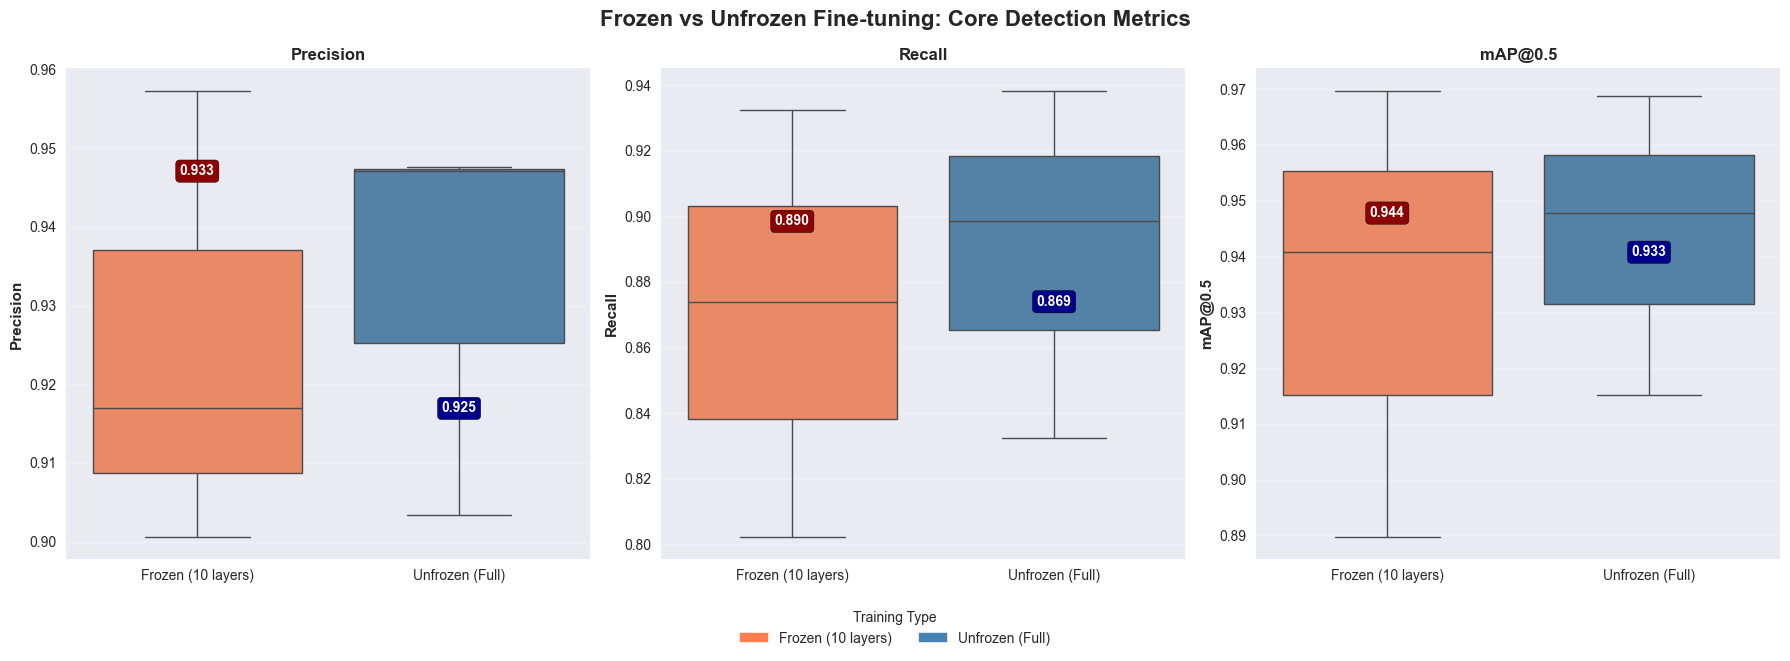

In [ ]:
# Main Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Frozen vs Unfrozen Fine-tuning: Core Detection Metrics', fontsize=16, fontweight='bold')

metrics_plot = [
    ('precision', 'Precision'),
    ('recall', 'Recall'),
    ('mAP50', 'mAP@0.5')
]

for idx, (metric, title) in enumerate(metrics_plot):
    ax = axes[idx]
    sns.boxplot(data=final_df, x='is_frozen', y=metric, ax=ax, palette=['coral', 'steelblue'])
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.set_xlabel('')
    ax.set_xticklabels(['Frozen (10 layers)', 'Unfrozen (Full)'])
    ax.set_ylabel(title, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    frozen_mean = frozen_df[metric].mean()
    unfrozen_mean = unfrozen_df[metric].mean()
    frozen_median = frozen_df[metric].median()
    unfrozen_median = unfrozen_df[metric].median()
    ax.text(0, frozen_median, f'{frozen_mean:.3f}', ha='center', va='center', fontweight='bold', color='white', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='darkred'))
    ax.text(1, unfrozen_median, f'{unfrozen_mean:.3f}', ha='center', va='center', fontweight='bold', color='white', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='darkblue'))

handles = [plt.Rectangle((0,0),1,1, color='coral'), plt.Rectangle((0,0),1,1, color='steelblue')]
fig.legend(handles, ['Frozen (10 layers)', 'Unfrozen (Full)'], title='Training Type', 
           loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.tight_layout()
plt.show()

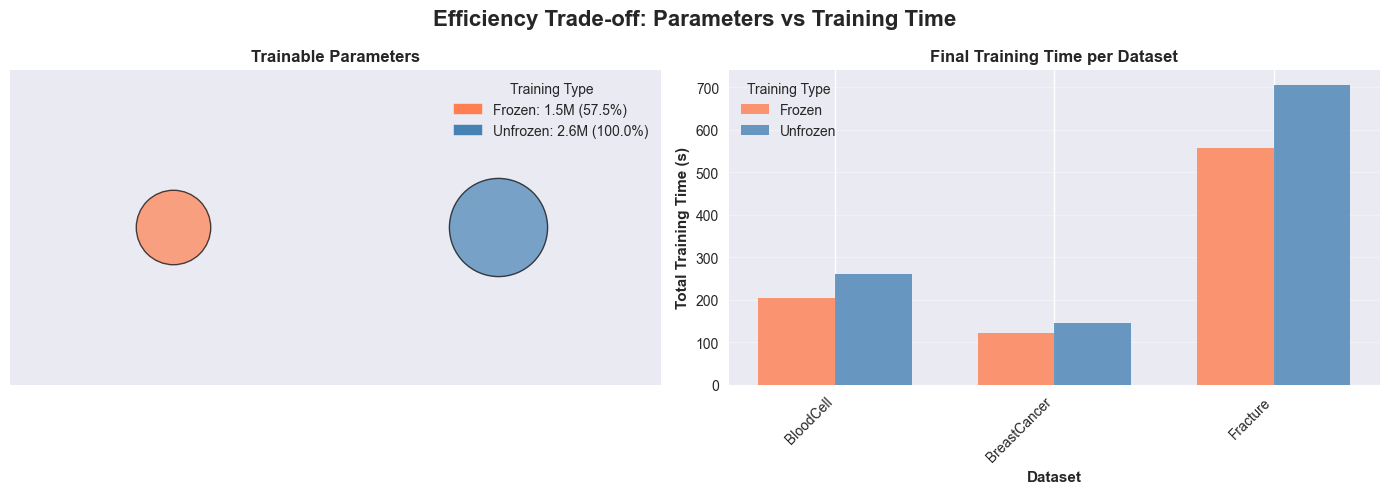

In [ ]:
# Efficiency Trade-off
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Efficiency Trade-off: Parameters vs Training Time', fontsize=16, fontweight='bold')

# First subplot: Trainable Parameters
frozen_df = df[df['is_frozen'] == True].copy()
unfrozen_df = df[df['is_frozen'] == False].copy()

# Select examples
frozen_example = frozen_df.loc[frozen_df['trainable_pct'].idxmin()] 
unfrozen_example = unfrozen_df.loc[unfrozen_df['trainable_pct'].idxmax()]

frozen_params_m = frozen_example['trainable_params'] / 1e6
frozen_pct = frozen_example['trainable_pct']
unfrozen_params_m = unfrozen_example['trainable_params'] / 1e6
unfrozen_pct = unfrozen_example['trainable_pct']

sizes = [frozen_pct * 50, unfrozen_pct * 50]  # Scale for visibility
axes[0].scatter([0], [0], s=sizes[0], alpha=0.7, color='coral', edgecolors='black', linewidths=1)
axes[0].scatter([1], [0], s=sizes[1], alpha=0.7, color='steelblue', edgecolors='black', linewidths=1)
axes[0].set_xlim(-0.5, 1.5)
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')
axes[0].set_title('Trainable Parameters', fontweight='bold')

# Custom legend with circles
import matplotlib.patches as mpatches
handles = [mpatches.Circle((0,0), radius=5, color='coral'), mpatches.Circle((0,0), radius=5, color='steelblue')]
labels = [f'Frozen: {frozen_params_m:.1f}M ({frozen_pct:.1f}%)', f'Unfrozen: {unfrozen_params_m:.1f}M ({unfrozen_pct:.1f}%)']
axes[0].legend(handles, labels, title='Training Type')
axes[0].grid(False)

# Second subplot: Final Training Time per Dataset (Frozen vs Unfrozen)
final_time_df = df[df['is_final']].groupby(['dataset', 'is_frozen'])['time'].mean().reset_index()
datasets = sorted(final_time_df['dataset'].unique())
x = np.arange(len(datasets))
width = 0.35

frozen_times = []
unfrozen_times = []
for dataset in datasets:
    frozen_time = final_time_df[(final_time_df['dataset'] == dataset) & (final_time_df['is_frozen'] == True)]['time']
    unfrozen_time = final_time_df[(final_time_df['dataset'] == dataset) & (final_time_df['is_frozen'] == False)]['time']
    frozen_times.append(frozen_time.mean() if not frozen_time.empty else 0)
    unfrozen_times.append(unfrozen_time.mean() if not unfrozen_time.empty else 0)

bars1 = axes[1].bar(x - width/2, frozen_times, width, label='Frozen', color='coral', alpha=0.8)
bars2 = axes[1].bar(x + width/2, unfrozen_times, width, label='Unfrozen', color='steelblue', alpha=0.8)

axes[1].set_xlabel('Dataset', fontweight='bold')
axes[1].set_ylabel('Total Training Time (s)', fontweight='bold')
axes[1].set_title('Final Training Time per Dataset', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(datasets, rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].legend(title='Training Type')

plt.tight_layout()
plt.show()

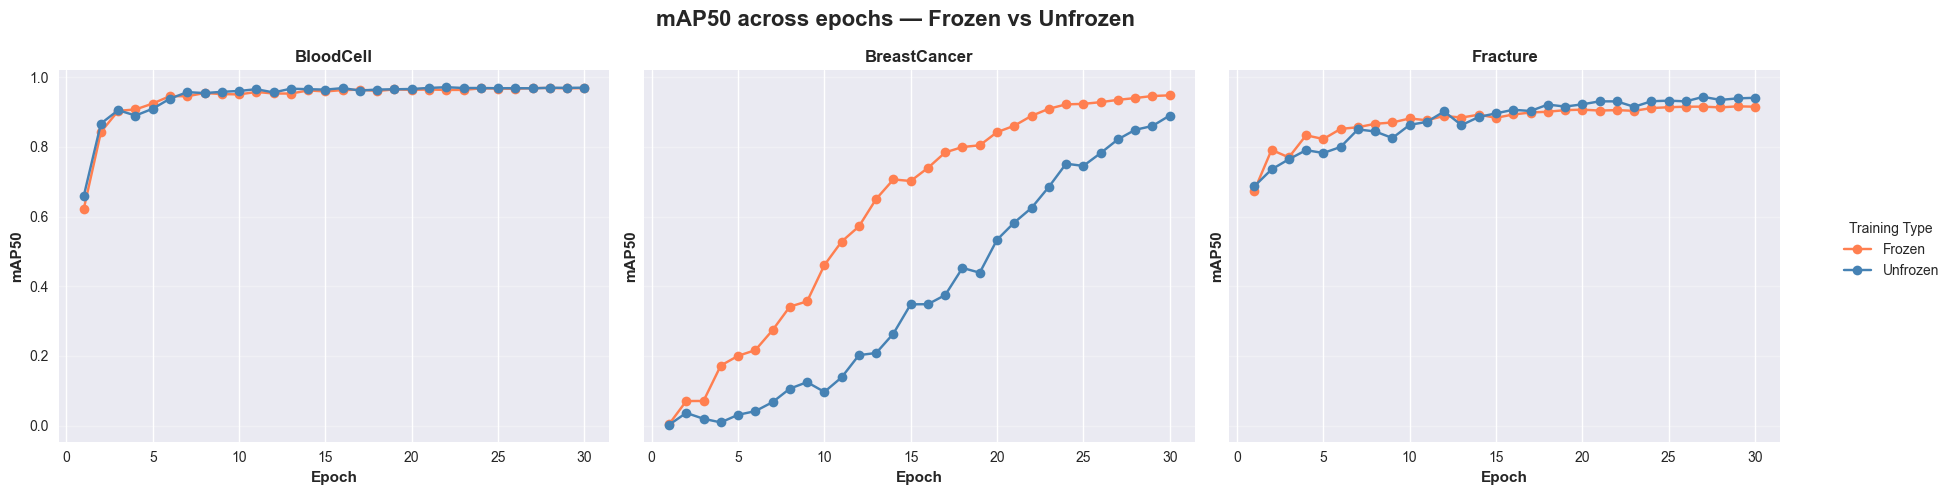

In [ ]:
# Plot mAP50 
epoch_df = df.copy()
metric = 'mAP50'
datasets = sorted(epoch_df['dataset'].unique())

# Prepare figure
n = len(datasets)
fig, axes = plt.subplots(1, n, figsize=(6 * max(1, n), 5), sharey=True)
if n == 1:
    axes = [axes]
fig.suptitle(f'{metric} across epochs — Frozen vs Unfrozen', fontsize=16, fontweight='bold')

for idx, dataset in enumerate(datasets):
    ax = axes[idx]
    sub = epoch_df[epoch_df['dataset'] == dataset]
    if sub.empty:
        ax.set_title(dataset)
        continue

    grp = sub.groupby(['epoch', 'is_frozen'])[metric].agg(['mean', 'std']).reset_index()

    pivot_mean = grp.pivot(index='epoch', columns='is_frozen', values='mean')
    pivot_std = grp.pivot(index='epoch', columns='is_frozen', values='std')

    # Ensure sorted by epoch
    pivot_mean = pivot_mean.sort_index()
    pivot_std = pivot_std.reindex(pivot_mean.index)

    epochs = pivot_mean.index.values

    # Plot frozen (True) and unfrozen (False)
    if True in pivot_mean.columns:
        y = pivot_mean[True].values
        yerr = pivot_std[True].values
        ax.plot(epochs, y, label='Frozen', color='coral', marker='o')
        ax.fill_between(epochs, y - yerr, y + yerr, color='coral', alpha=0.2)
    if False in pivot_mean.columns:
        y2 = pivot_mean[False].values
        y2err = pivot_std[False].values
        ax.plot(epochs, y2, label='Unfrozen', color='steelblue', marker='o')
        ax.fill_between(epochs, y2 - y2err, y2 + y2err, color='steelblue', alpha=0.2)

    ax.set_title(f'{dataset}', fontweight='bold')
    ax.set_xlabel('Epoch', fontweight='bold')
    ax.set_ylabel(metric, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

# Global legend outside to the right
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, title='Training Type', loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
fig.subplots_adjust()
plt.show()

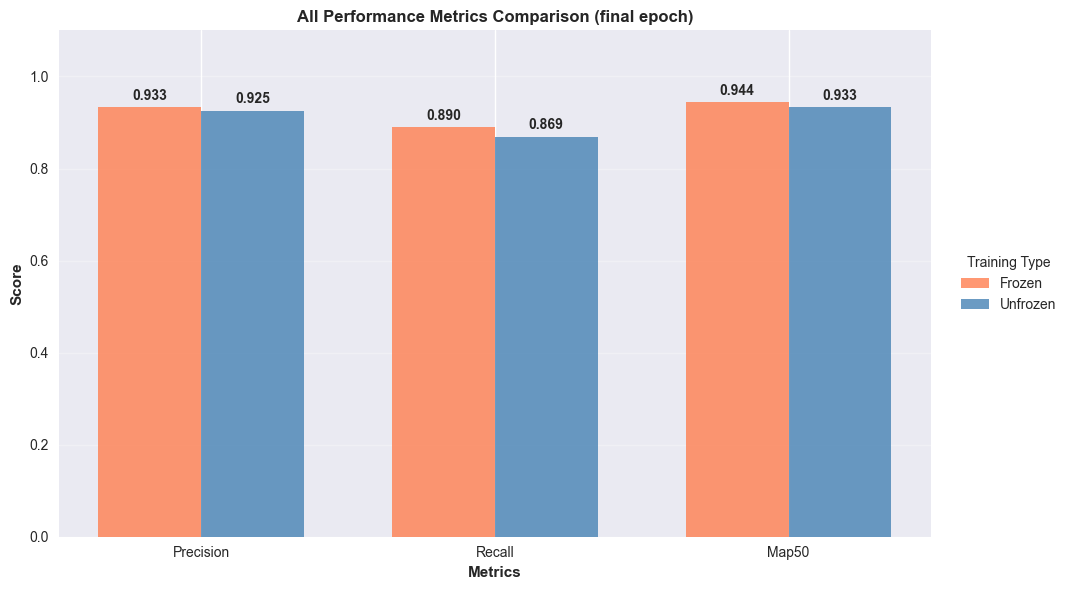

In [ ]:
# Metrics Comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics_compare = ['precision', 'recall', 'mAP50']
x = np.arange(len(metrics_compare))
width = 0.35

frozen_final = final_df[final_df['is_frozen'] == True]
unfrozen_final = final_df[final_df['is_frozen'] == False]

def safe_mean(df, col):
    return float(df[col].mean()) if len(df) > 0 else np.nan

frozen_means = [safe_mean(frozen_final, m) for m in metrics_compare]
unfrozen_means = [safe_mean(unfrozen_final, m) for m in metrics_compare]

bars1 = ax.bar(x - width/2, frozen_means, width, label='Frozen', color='coral', alpha=0.8)
bars2 = ax.bar(x + width/2, unfrozen_means, width, label='Unfrozen', color='steelblue', alpha=0.8)

ax.set_xlabel('Metrics', fontweight='bold')
ax.set_ylabel('Score', fontweight='bold')
ax.set_title('All Performance Metrics Comparison (final epoch)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', ' ').title() for m in metrics_compare])
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.1)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.legend(title='Training Type', loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
fig.subplots_adjust(right=0.78) 
plt.show()

## 🧮 Statistical Tests

In [ ]:
# Compute paired differences
metrics = ['precision', 'recall', 'mAP50']
grouped = final_df.groupby(['dataset', 'is_frozen'])[metrics].mean().reset_index()

paired_results = []
for dataset in final_df['dataset'].unique():
    frozen_mean = grouped[(grouped['dataset'] == dataset) & (grouped['is_frozen'] == True)]
    unfrozen_mean = grouped[(grouped['dataset'] == dataset) & (grouped['is_frozen'] == False)]
    if not frozen_mean.empty and not unfrozen_mean.empty:
        fr = frozen_mean.iloc[0][metrics].to_dict()
        ur = unfrozen_mean.iloc[0][metrics].to_dict()
        row = {'dataset': dataset}
        for m in metrics:
            row[f'frozen_{m}'] = fr.get(m, np.nan)
            row[f'unfrozen_{m}'] = ur.get(m, np.nan)
        paired_results.append(row)

if len(paired_results) > 0:
    paired_df = pd.DataFrame(paired_results)
    print(f"Using {len(paired_df)} dataset pairs for paired tests (datasets missing a condition were excluded).")
    print("Paired t-test (Unfrozen vs Frozen):")
    print(f"{'Metric':<15} {'t-stat':<10} {'p-value':<10} {'Significance'}")
    print("-" * 50)

    for metric in metrics:
        frozen_col = f'frozen_{metric}'
        unfrozen_col = f'unfrozen_{metric}'
        
        a = paired_df[unfrozen_col].dropna()
        b = paired_df[frozen_col].dropna()

        common_idx = a.index.intersection(b.index)
        a = a.loc[common_idx]
        b = b.loc[common_idx]

        if len(common_idx) >= 2:
            t_stat, p_value = stats.ttest_rel(a, b)
            sig = '*' if p_value < 0.05 else '(ns)'
            print(f"{metric:<15} {t_stat:<10.3f} {p_value:<10.4f} {sig}")
        else:
            print(f"{metric:<15} {'NA':<10} {'NA':<10} Not enough pairs (need >=2)")
else:
    print("Not enough paired data for statistical tests.")

Using 3 dataset pairs for paired tests (datasets missing a condition were excluded).
Paired t-test (Unfrozen vs Frozen):
Metric          t-stat     p-value    Significance
--------------------------------------------------
precision       -0.394     0.7314     (ns)
recall          -0.501     0.6661     (ns)
mAP50           -0.422     0.7142     (ns)
